# Итоговоый проект по курсу "Библиотеки Python для Data Science" <a class='anchor' id='begin'>

Тема: "Построение модели машинного обучения для предсказания факта невыполнения кредитных обязательств"<br>
Студент: Николай Пахомов ([kaggle](https://www.kaggle.com/kikoooiemama), [telegram](https://t.me/kikoooiemama))<br>
Преподаватель: Светлана Медведева<br>

## Содержание
* [Итоговоый проект по курсу "Библиотеки Python для Data Science: продолжение"](#begin) 
    * [Задание](#task)
    * [Загрузка библиотек и скриптов](#load_help)
    * [Загрузка данных](#load_data)
    * [1. Анализ данных](#eda)
    * [2. Обработка выбросов и пропусков](#nan)
    * [3. Построение новых признаков](#features)
    * [4. Отбор признаков](#features_selection)
    * [5. Разбиение на train и test](#split)
    * [6. Построение модели](#modeling)
    * [7. Прогнозирование на тестовом датасете](#prediction)

---
## Задание <a class='anchor' id='task'>

_Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета._
    
    
**Материалы к проекту (файлы):** 
* [train.csv](https://www.kaggle.com/c/gb-credit-default/data?select=train.csv), 
* [test.csv](https://www.kaggle.com/c/gb-credit-default/data?select=test.csv),
* [sample_submission.csv](https://www.kaggle.com/c/gb-credit-default/data?select=sample_submission.csv)

**Целевая переменная:**
Credit Default - факт невыполнения кредитных обязательств

**Основная метрика:**
F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

---
## Загрузка библиотек и скриптов <a class='anchor' id='load_help'>

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV
# import xgboost as xgb

from catboost import CatBoostClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """       
    """
    print("Train F1:\t" + str(round(f1_score(train_true_values, train_pred_values), 4)))
    print("Test F1:\t" + str(round(f1_score(test_true_values, test_pred_values), 4)))
    get_classification_report(train_true_values, train_pred_values, test_true_values, test_pred_values)

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ 
    Выполнение итерации по всем столбцам фрейма данных, чтобы изменить тип данных для уменьшения используемой памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

---
## Загрузка данных <a class='anchor' id='load_data'>

### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Путь к директориям и файлам

In [6]:
TRAIN_DATASET_PATH = './Datasets/train.csv' # y_train, y_valid
TEST_DATASET_PATH = './Datasets/test.csv' # y_test
SUBMIT_DATASET_PATH = './Datasets/sample_submission.csv'
SUBMIT_FILE_NAME = 'pakhomov_predictions.csv'

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [8]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [11]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [12]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [13]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [14]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [15]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [16]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [17]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

---
## 1. Анализ данных <a class='anchor' id='eda'>

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

Параметры с пропусками: Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score

In [19]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Целевая переменная

In [20]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

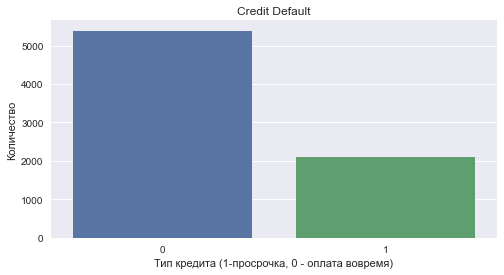

In [21]:
counts = train_df['Credit Default'].value_counts()
    
plt.figure(figsize=(8,4))    
plt.title('Credit Default')
sns.barplot(counts.index, counts.values)
plt.xlabel('Тип кредита (1-просрочка, 0 - оплата вовремя)')
plt.ylabel('Количество')
plt.show()

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту). Количество просроченных кредитов примерно треть. Две трети кредитов без просрочек. Пропусков нет.

### Количественные признаки

In [22]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [23]:
train_df_categorical_features = train_df.select_dtypes(include=['category'])
train_df_numerical_features = train_df.drop(train_df_categorical_features, axis=1)
train_df_numerical_features.drop(['Credit Default'], axis=1, inplace=True)

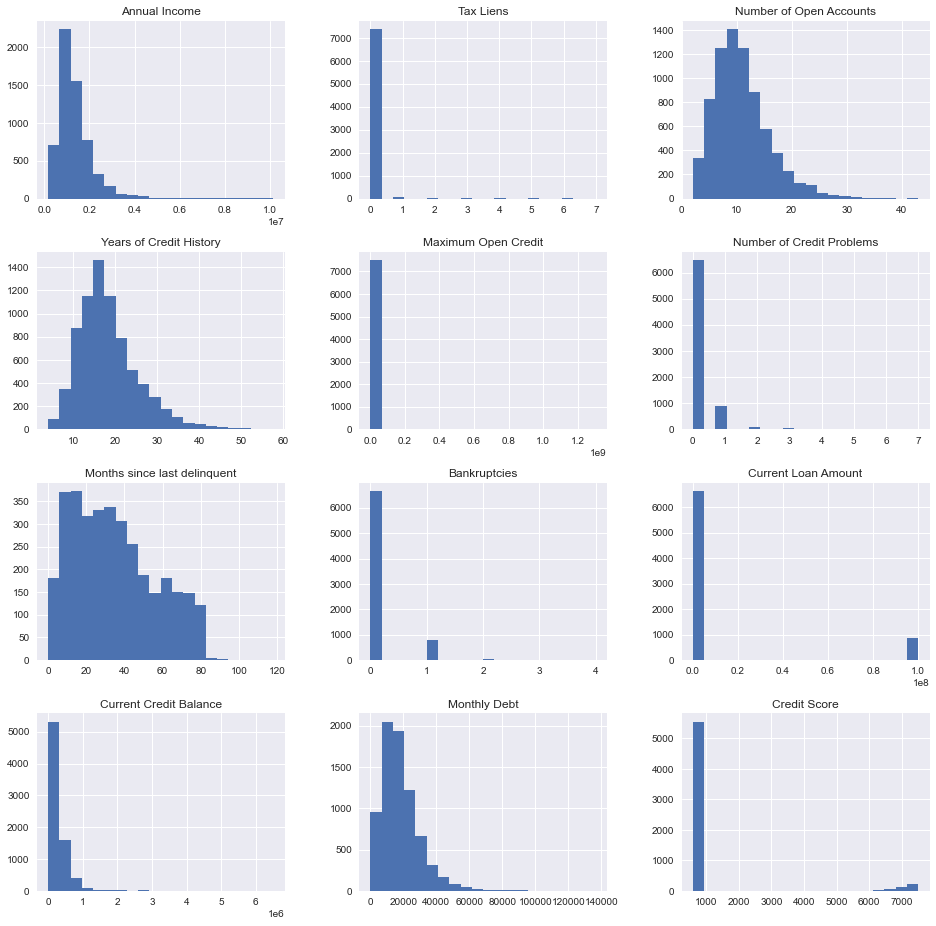

In [24]:
train_df_numerical_features.hist(figsize=(16,16), bins=20, grid=True);

* Credit Score - выбросы в интервале от [6000,7000];
* Current Loan Amount - выбросы в области значения 1.0;
* Maximum Open Credit - по факту не видно на гистограмме, однако есть множитель горизонтальной оси 1e9;

In [25]:
train_df_numerical_features

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,100000000.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,100000000.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,129360.0,73492.0,1900.0,697.0
7496,1533984.0,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0
7497,1878910.0,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,100000000.0,477812.0,12479.0,748.0
7498,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,615274.0,476064.0,37118.0,NaN


In [26]:
train_df_numerical_features.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


In [27]:
train_df_numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5943 non-null   float32
 1   Tax Liens                     7500 non-null   float32
 2   Number of Open Accounts       7500 non-null   float32
 3   Years of Credit History       7500 non-null   float32
 4   Maximum Open Credit           7500 non-null   float32
 5   Number of Credit Problems     7500 non-null   float32
 6   Months since last delinquent  3419 non-null   float32
 7   Bankruptcies                  7486 non-null   float32
 8   Current Loan Amount           7500 non-null   float32
 9   Current Credit Balance        7500 non-null   float32
 10  Monthly Debt                  7500 non-null   float32
 11  Credit Score                  5943 non-null   float32
dtypes: float32(12)
memory usage: 351.7 KB


#### Annual Income (Годовой доход)

In [28]:
train_df['Annual Income'].isnull().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

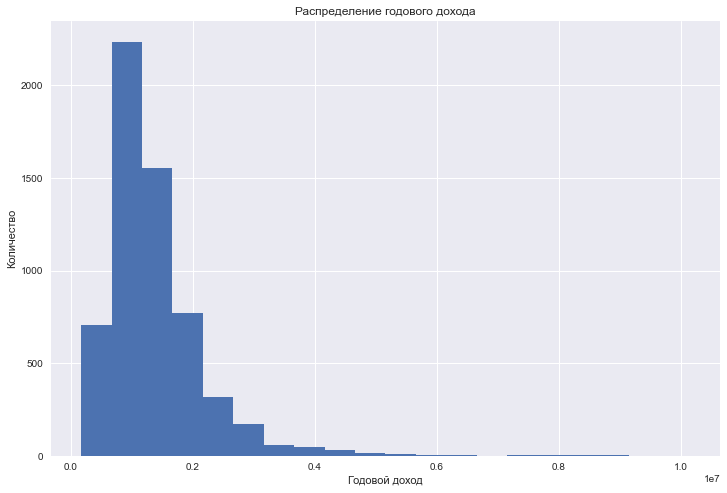

In [29]:
plt.figure(figsize = (12, 8))

train_df['Annual Income'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Годовой доход')

plt.title('Распределение годового дохода')
plt.show()

* 1557 пропусков;
* Максимальное и минимальное значение вполне адекватное;
* Довольно длинный хвост.

То что есть хвост, считаю, что ничего страшного. Но пропуски нужно будет заменить, возможно средним или модой по какому-нибудь признаку и тд.

#### Tax Liens (Налоговые обременения)

In [30]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

* Нет пропусков
* Возможно, что 0 означает, что клиент не обременен какими-то налогами?
* Возможно, что число это тип налоговой нагрузки, начиная с 0.

#### Number of Open Accounts (Количество открытых счетов)

In [31]:
train_df['Number of Open Accounts'].value_counts().sort_index().head(5)

2.0     28
3.0     95
4.0    212
5.0    325
6.0    504
Name: Number of Open Accounts, dtype: int64

In [32]:
train_df['Number of Open Accounts'].value_counts().sort_index().tail(5)

37.0    2
38.0    1
41.0    1
42.0    1
43.0    1
Name: Number of Open Accounts, dtype: int64

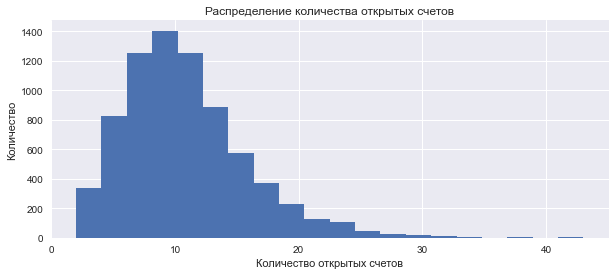

In [33]:
plt.figure(figsize = (10, 4))

train_df['Number of Open Accounts'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Количество открытых счетов')

plt.title('Распределение количества открытых счетов')
plt.show()

* Нет пропусков;
* Видим, что у всех есть очень много счетов;
* Макс. значение 43, минимальное значение 2. По сути значения > 30 можно считать выбросом. 

#### Years of Credit History (Количество лет кредитной истории)

In [34]:
train_df['Years of Credit History'].value_counts().sort_index()

4.000000     1
4.300000     1
4.500000     2
4.700000     2
4.800000     4
            ..
51.299999    1
51.500000    1
51.900002    1
52.200001    1
57.700001    1
Name: Years of Credit History, Length: 408, dtype: int64

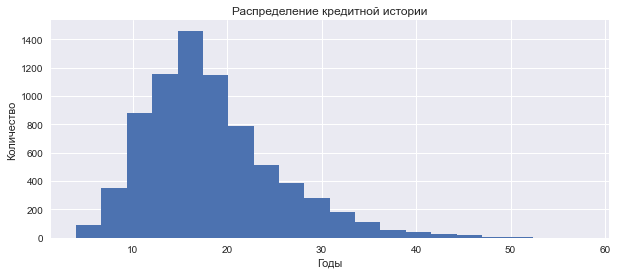

In [35]:
plt.figure(figsize = (10, 4))

train_df['Years of Credit History'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Годы')

plt.title('Распределение кредитной истории')
plt.show()

* Нет пропусков;
* Странных значений тоже нет.

#### Maximum Open Credit (максимальная кредитная сумма, которая когда-либо была доступна клиенту)

In [36]:
train_df['Maximum Open Credit'].value_counts().sort_index()

0.000000e+00    65
4.334000e+03     1
6.556000e+03     1
6.622000e+03     1
1.089000e+04     1
                ..
4.092390e+07     1
5.756256e+07     1
2.655129e+08     1
3.800523e+08     1
1.304726e+09     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

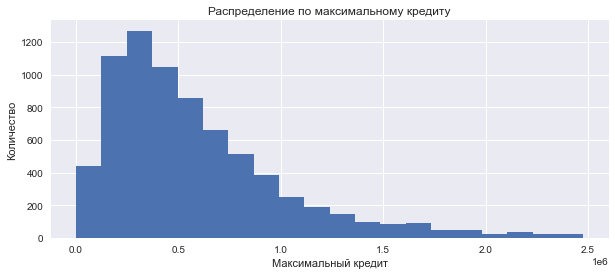

In [37]:
plt.figure(figsize = (10, 4))

mask = train_df['Maximum Open Credit'] < 2500000
train_df.loc[mask, 'Maximum Open Credit'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Максимальный кредит')

plt.title('Распределение по максимальному кредиту')
plt.show()

In [38]:
mask = train_df['Maximum Open Credit'] > 10000000
len(train_df.loc[mask])

19

* Нет пропусков
* Есть длинный хвост. Скорее всего это выбросы. По идее значения выше несколько миллионов можно считать выбросом, но надо смотреть другие признаки

#### Number of Credit Problems (Количество проблем с кредитом)

In [39]:
train_df['Number of Credit Problems'].value_counts().sort_index()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

* Пропусков нет
* Возможно, что 0 означает, что клиент не имеет проблем?
* Возможно, что число это тип проблемы, начиная с 0. И признак на самом деле категориальный...

#### Months since last delinquent (Количество месяцев с последней просрочки платежа)

In [40]:
train_df['Months since last delinquent'].isnull().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

In [41]:
train_df['Months since last delinquent'].value_counts().sort_index()

0.0      18
1.0      26
2.0      25
3.0      30
4.0      31
         ..
84.0      1
86.0      1
91.0      1
92.0      1
118.0     1
Name: Months since last delinquent, Length: 89, dtype: int64

* 4081 пропуск
* Можно предположить что пропуски означают что у клиента не было просроченных платежей, однако есть 

#### Bankruptcies (Банкротства)

In [42]:
train_df['Bankruptcies'].isnull().value_counts()

False    7486
True       14
Name: Bankruptcies, dtype: int64

In [43]:
train_df['Bankruptcies'].value_counts().sort_index()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

* 14 пропусков
* Все значения в принципе логичные, ничего странного нет, потому что действительно у большинства людей нет никаких банкротств

#### Current Loan Amount (Сумма, которую еще предстоит выплатить клиенту)

In [44]:
train_df['Current Loan Amount'].describe()

count         7500.0
mean      11873135.0
std       31926302.0
min          11242.0
25%         180169.0
50%         309573.0
75%         519882.0
max      100000000.0
Name: Current Loan Amount, dtype: float64

In [45]:
train_df['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

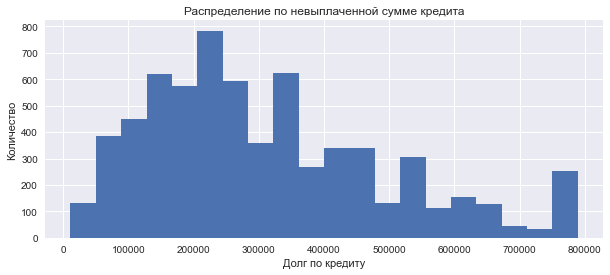

In [46]:
plt.figure(figsize = (10, 4))

mask = train_df['Current Loan Amount'] < 100000000
train_df.loc[mask, 'Current Loan Amount'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Долг по кредиту')

plt.title('Распределение по невыплаченной сумме кредита')
plt.show()

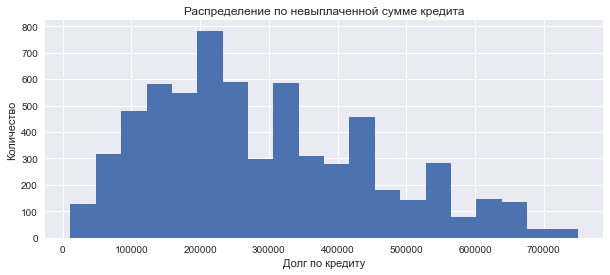

In [47]:
plt.figure(figsize = (10, 4))

mask = train_df['Current Loan Amount'] < 750000
train_df.loc[mask, 'Current Loan Amount'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Долг по кредиту')

plt.title('Распределение по невыплаченной сумме кредита')
plt.show()

In [48]:
mask = train_df['Current Loan Amount'] < 100000000
train_df.loc[mask, 'Current Loan Amount'].describe()

count      6630.00000
mean     309024.40625
std      182294.00000
min       11242.00000
25%      172744.00000
50%      265826.00000
75%      430100.00000
max      789030.00000
Name: Current Loan Amount, dtype: float64

* Нет пропусов
* Скорее всего здесь есть выбросы. Значение 100000000.0. Выбросы можно заменить средним или модой.

#### Current Credit Balance (сумма, которую может тратить клиент с кредитного счета)

In [49]:
train_df['Current Credit Balance'].value_counts().sort_index()

0.0          53
19.0          3
57.0          2
76.0          2
95.0          1
             ..
4209659.0     1
4249673.0     1
4367245.0     1
4720132.0     1
6506797.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

In [50]:
train_df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178713e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [51]:
len(train_df[train_df['Current Credit Balance'] > 1000000])

188

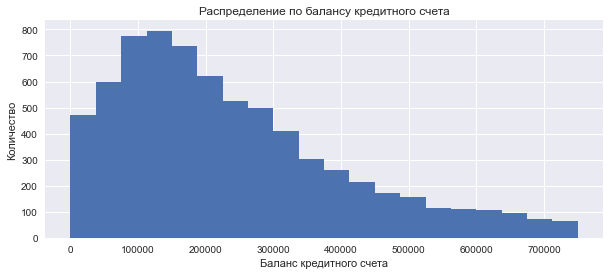

In [52]:
plt.figure(figsize = (10, 4))

mask = train_df['Current Credit Balance'] < 750000
train_df.loc[mask, 'Current Credit Balance'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Баланс кредитного счета')

plt.title('Распределение по балансу кредитного счета')
plt.show()

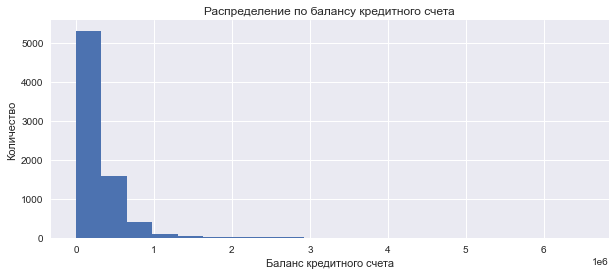

In [53]:
plt.figure(figsize = (10, 4))
train_df['Current Credit Balance'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Баланс кредитного счета')

plt.title('Распределение по балансу кредитного счета')
plt.show()

In [54]:
mask = train_df['Current Credit Balance'] < 800000
train_df.loc[mask, 'Current Credit Balance'].describe()

count      7160.000000
mean     241565.671875
std      174790.312500
min           0.000000
25%      110285.500000
50%      198654.500000
75%      332077.250000
max      799387.000000
Name: Current Credit Balance, dtype: float64

* Нет пропусков
* Есть выбросы, возможно от [750000, 850000]

#### Monthly Debt (Ежемесячный долг/платеж)

In [55]:
train_df['Monthly Debt'].describe()

count      7500.000000
mean      18314.453125
std       11926.758789
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

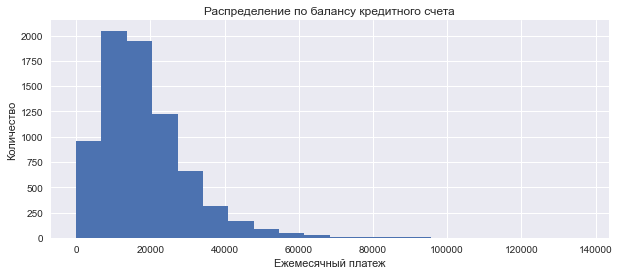

In [56]:
plt.figure(figsize = (10, 4))
train_df['Monthly Debt'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Ежемесячный платеж')

plt.title('Распределение по балансу кредитного счета')
plt.show()

In [57]:
train_df['Monthly Debt'].quantile(.99)

58113.130000000005

* Пропусков нет
* Есть значения выше 58к, которые являются 1 перцентилем от общей выборки.

#### Credit Score (Баллы кредитного рейтинга)

In [58]:
train_df['Credit Score'].isnull().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

In [59]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087524
std      1604.447510
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

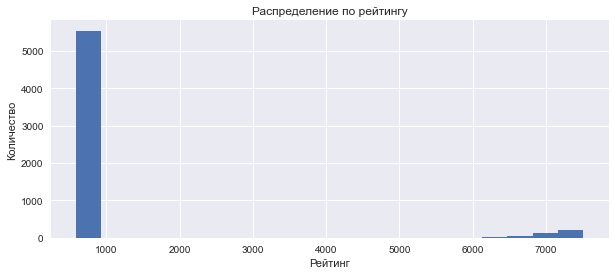

In [60]:
plt.figure(figsize = (10, 4))
train_df['Credit Score'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Рейтинг')

plt.title('Распределение по рейтингу')
plt.show()

In [61]:
train_df[train_df['Credit Score'] < 850]['Credit Score'].count()

5543

In [62]:
train_df[train_df['Credit Score'] >= 850]['Credit Score'].count()

400

Кредитный рейтинг в РФ имеет значения от 1 до 999.

* 1557 Пропусков
* Есть значения платежа выше 100к
* Очень серьезные выбросы

Выбросы как вариант можно разделить на 10 или присвоить им среднее/моду, либо посмотреть также по матрице корреляций связь с другими признаками.

[Диапазоны кредитного рейтинга](https://nesrakonk.ru/what-do-credit-score-ranges-mean/)

### Категориальные признаки

In [63]:
for cat_colname in train_df.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n')
    print('Nan values:' + '\n' + str(train_df[cat_colname].isnull().value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Nan values:
False    7500
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Nan values:
False    7129
True      371
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house  

Здесь никаких выбросов нет, есть только пропуски у признака 'Years in current job'.
Пропуски можно заполнить модой или считать что человек безработный.

### Матрица корреляций

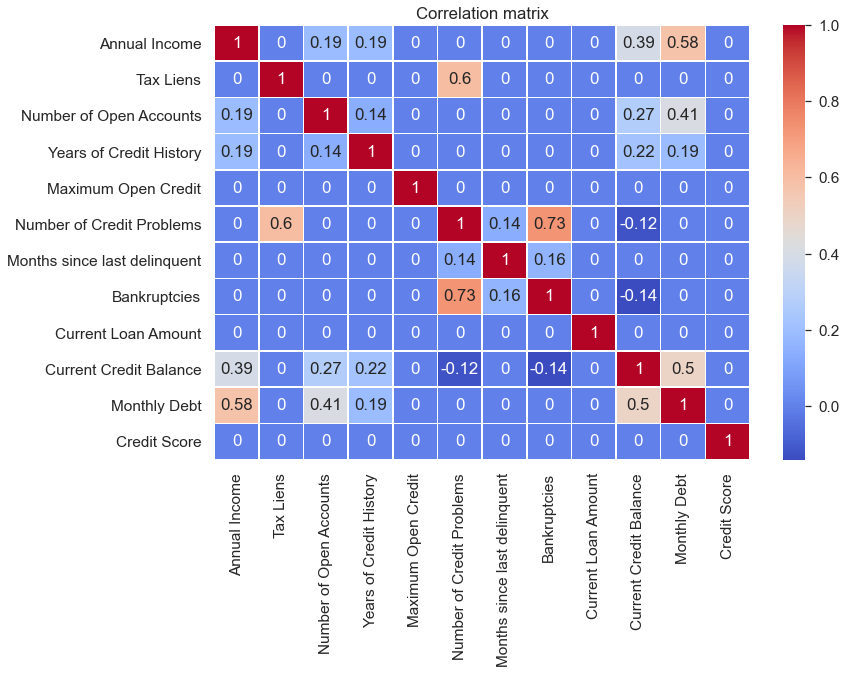

In [64]:
plt.figure(figsize = (12,8))

sns.set(font_scale=1.4)
corr_matrix = train_df.drop(columns='Credit Default').corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.12] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
# plt.savefig('Correlation matrix.png')
plt.show()

Сильные корреляции:
* ***Annual Income***, ***Number of Open Accounts***, ***Years of Credit History***, ***Current Credit Balance***, ***Monthly Debt*** - положительная корреляция между всеми признаками!
* ***Number of Credit Problems*** и ***Tax Liens*** - сильная корреляция, то есть обременение налогами увеличивает проблемы и наоборот.
* ***Number of Credit Problems*** и ***Bankruptcies*** - сильная корреляция, то есть можно судить что проблемы с кредитами приводят к банкротствам. Однако банкротства не коррелируют с обременением налогами.
* ***Months since last delinquent*** имеет небольшую корреляцию с ***Number of Credit Problems*** и ***Bankruptcies***, что логично. Просрочки платежей могут вызвать проблемы с кредитом и перерости в банкротства. 
* ***Current Credit Balance*** имеет небольшую отрицательную корреляцию с ***Number of Credit Problems*** и ***Bankruptcies***. Высокий баланс кредитного счета означает, что деньги мы в кредит не брали, а значит и возможным проблем будет меньше и вероятность банкротства ниже.


In [65]:
mask = train_df['Current Loan Amount'] < 100000000
train_df.loc[mask, 'Current Loan Amount'].describe()

count      6630.00000
mean     309024.40625
std      182294.00000
min       11242.00000
25%      172744.00000
50%      265826.00000
75%      430100.00000
max      789030.00000
Name: Current Loan Amount, dtype: float64

In [66]:
train_df.loc[mask, 'Current Loan Amount'].median()

265826.0

---
## 2. Обработка выбросов и пропусков <a class='anchor' id='nan'>

In [67]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999998
        
    def fit(self, X):
        """Сохранение статистик""" 
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        """Трансформация данных"""

        # Credit score. Разделили на 10.
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        # Current Loan Amount. Замена медианой.
        mask = X['Current Loan Amount'] < 100000000
        cla_median = X.loc[mask, 'Current Loan Amount'].median()
        X.loc[X['Current Loan Amount'] > self.max_credit, 'Current Loan Amount'] = cla_median
        
        # Maximum Open Credit
        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit'] = self.max_credit
               
        # Annual Income
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)
        
        # Years in current job
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

---
## 3. Построение новых признаков <a class='anchor' id='features'>

In [68]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # Term: 'Long Term'
        X['Long Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        # Years in current job: no new feature
        X['Years in current job'] = X['Years in current job'].map({
                                                            '10+ years':10, 
                                                            '9 years': 9,
                                                            '8 years': 8,
                                                            '7 years':7,
                                                            '6 years':6,
                                                            '5 years':5,
                                                            '4 years':4,
                                                            '3 years':3,
                                                            '2 years':2,
                                                            '1 year':1,
                                                            '< 1 year':0
                                                            })          
        
        # Home Ownership: 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent',  
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1) 
        
        # Credit Score: 'Credit Score Cat'
        X = self.credit_score_to_cat(X)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

---
## 4. Отбор признаков <a class='anchor' id='features_selection'>

In [69]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [70]:
feature_names = [
#     'Home Ownership',
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
#     'Months since last delinquent',
    'Bankruptcies',
#     'Purpose',
#     'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score'
]

new_feature_names = [ 
    'Long Term', 
    'Have Mortgage',
    'Home Mortgage', 
    'Own Home', 
    'Rent', 
    'Credit Score Cat'
]

target_name = 'Credit Default'

---
## 5. Разбиение тренировочной выборки на train и valid <a class='anchor' id='split'>

In [71]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [72]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [74]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)  #  fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [75]:
X_train.shape, X_valid.shape

((5025, 16), (2475, 16))

In [76]:
features_generator = FeatureGenetator()
features_generator.fit(X_train, y_train)  #  fit применяем только к X_train, y_train

X_train = features_generator.transform(X_train)
X_valid = features_generator.transform(X_valid)

In [77]:
X_train.shape, X_valid.shape

((5025, 22), (2475, 22))

### Применение отобранных признаков
см. [4. Отбор признаков](#features_selection)

In [78]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

In [79]:
X_train.shape, X_valid.shape

((5025, 18), (2475, 18))

In [80]:
# Посмотрим на размерности и пропуски в данных. После обработки их не должно быть.
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

In [81]:
X_train.isna().sum()

Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Long Term                    0
Have Mortgage                0
Home Mortgage                0
Own Home                     0
Rent                         0
Credit Score Cat             0
dtype: int64

### Балансировка целевой переменной

In [82]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [83]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3611
1    2828
Name: Credit Default, dtype: int64

In [84]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

---
## 6. Построение модели <a class='anchor' id='modeling'>

### Обучение

<u>class_weights</u>

Class weights. The values are used as multipliers for the object weights. This parameter can be used for solving binary classification and multiclassification problems.

For imbalanced datasets with binary classification the weight multiplier can be set to 1 for class 0 and to 
$\left(\frac{sum\_negative}{sum\_positive}\right)$ for class 1.

In [85]:
class_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
class_weight

1.2768741159830268

In [86]:
catboost_model = CatBoostClassifier(
                                     silent=True, 
                                     random_state=17,
                                     class_weights=[1, class_weight],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=2500,
                                     max_depth=5,
                                     min_data_in_leaf=5
                                    )
catboost_model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
# parameters = {
#     'silent':[True],
#     'random_state':[17],
#     'class_weights':[[1, class_weight]],
#     'eval_metric':['F1'],
#     'early_stopping_rounds':[15,20,25],
#     'use_best_model':[True],
#     'custom_metric':['Precision', 'Recall'],
#     'iterations': np.linspace(10, 200, 20, endpoint=True),
#     'max_depth': [5,6,7,8,9],
#     'min_data_in_leaf': [3,4,5,6,7],
# #    'num_boost_round': [1500],
#     'learning_rate': np.linspace(0.01, 0.3, 10, endpoint=True)
# }

# catboost_model = GridSearchCV(
#     estimator=CatBoostClassifier(),
#     param_grid=parameters,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1
# )

# catboost_model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))
# catboost_model.best_params_

### Оценка модели

In [88]:
y_train_preds = catboost_model.predict(X_train)
y_test_preds = catboost_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train F1:	0.6264
Test F1:	0.4909
TRAIN

              precision    recall  f1-score   support

           0       0.72      0.51      0.60      3611
           1       0.54      0.74      0.63      2828

    accuracy                           0.61      6439
   macro avg       0.63      0.63      0.61      6439
weighted avg       0.64      0.61      0.61      6439

TEST

              precision    recall  f1-score   support

           0       0.83      0.51      0.63      1776
           1       0.37      0.73      0.49       699

    accuracy                           0.57      2475
   macro avg       0.60      0.62      0.56      2475
weighted avg       0.70      0.57      0.59      2475

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               907  869
1               189  510


### Важность признаков

In [89]:
feature_importances = pd.DataFrame(zip(X_train.columns, catboost_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
8,Current Loan Amount,30.029369
12,Long Term,29.935113
0,Annual Income,18.144061
17,Credit Score Cat,10.770817
11,Credit Score,4.034643
16,Rent,2.436809
3,Number of Open Accounts,2.171857
2,Tax Liens,1.268817
1,Years in current job,1.208515
4,Years of Credit History,0.000000


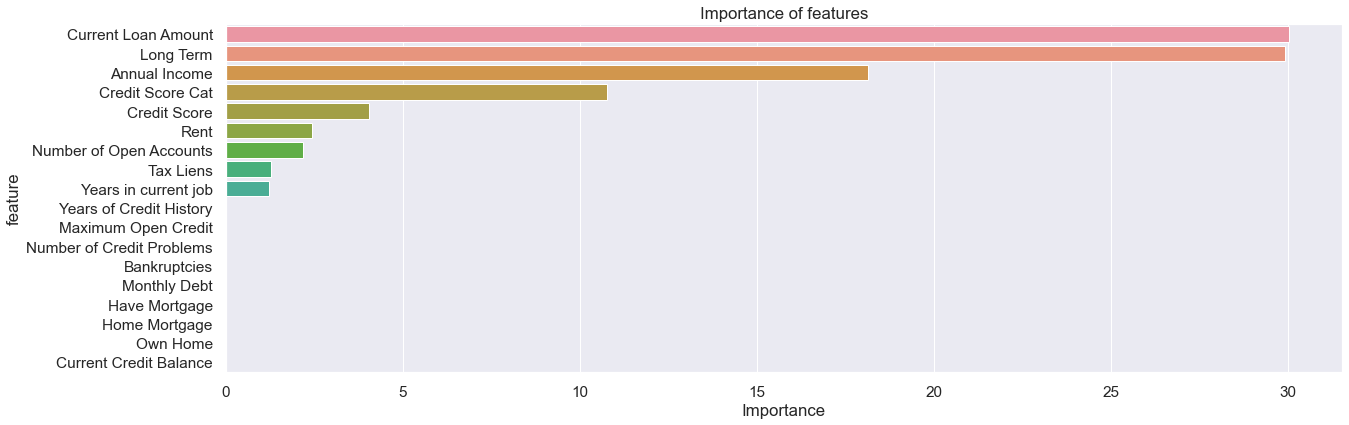

In [90]:
show_feature_importances(X_train.columns, catboost_model.feature_importances_, get_top=15)

---
## 7. Прогнозирование на тестовом датасете <a class='anchor' id='prediction'>

In [91]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = preprocessor.transform(test_df)
test_df = features_generator.transform(test_df)
test_df = test_df[feature_names + new_feature_names]

In [92]:
X_train.shape, X_valid.shape, test_df.shape

((6439, 18), (2475, 18), (2500, 18))

In [93]:
test_df.isna().sum().sum()

0

In [94]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [95]:
predictions = catboost_model.predict(test_df)
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [96]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [97]:
submit.to_csv(SUBMIT_FILE_NAME, index=False)